In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2023-07-06 18:18:59.666270: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 18:19:00.057350: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train = pd.read_csv('train_fin.csv')
test = pd.read_csv('test_fin.csv')

train['날짜'] = pd.to_datetime(train['년'].astype(str) + '-' + train['월'].astype(str))
test['날짜'] = pd.to_datetime(test['년'].astype(str) + '-' + test['월'].astype(str))

In [3]:
train.drop(['년', '월'], axis = 1, inplace = True)
test.drop(['년', '월'], axis = 1, inplace = True)

In [4]:
new_order = ['날짜', '수온(℃)', 'cum_rainfall', 'PM10', '수소이온농도', 'pollution_score']
train = train.reindex(columns=new_order)
test = test.reindex(columns=new_order)

In [5]:
train

,날짜,수온(℃),cum_rainfall,PM10,수소이온농도,pollution_score
0,2018-01-01,2.100000,0.000000,36.916667,7.900000,2.000000
1,2018-02-01,6.900000,0.000000,51.363636,7.500000,3.000000
2,2018-03-01,13.625000,1.875000,46.317434,7.450000,2.750000
3,2018-04-01,16.525000,2.750000,56.099702,7.400000,3.000000
4,2018-05-01,20.640000,12.700000,55.383333,7.380000,2.800000
5,2018-06-01,25.200000,3.625000,33.777586,7.450000,1.750000
6,2018-07-01,27.200000,0.250000,22.206439,7.575000,1.500000
7,2018-08-01,28.766667,0.166667,19.616287,7.700000,1.333333
8,2018-09-01,23.700000,1.166667,22.670070,7.733333,1.333333
9,2018-10-01,18.033333,0.000000,21.780797,7.833333,0.666667


In [6]:
df =  pd.concat([train,test], axis = 0)
df = df.reset_index()
df.drop('index', axis = 1, inplace=True)
df

,날짜,수온(℃),cum_rainfall,PM10,수소이온농도,pollution_score
0,2018-01-01,2.100000,0.000000,36.916667,7.900,2.000000
1,2018-02-01,6.900000,0.000000,51.363636,7.500,3.000000
2,2018-03-01,13.625000,1.875000,46.317434,7.450,2.750000
3,2018-04-01,16.525000,2.750000,56.099702,7.400,3.000000
4,2018-05-01,20.640000,12.700000,55.383333,7.380,2.800000
...,...,...,...,...,...,...
59,2022-12-01,6.866667,0.333333,33.236111,7.800,1.666667
60,2023-01-01,10.000000,0.000000,75.000000,7.500,2.000000
61,2023-02-01,8.450000,0.000000,35.500000,7.900,2.000000
62,2023-03-01,13.700000,1.625000,93.750000,7.700,2.250000


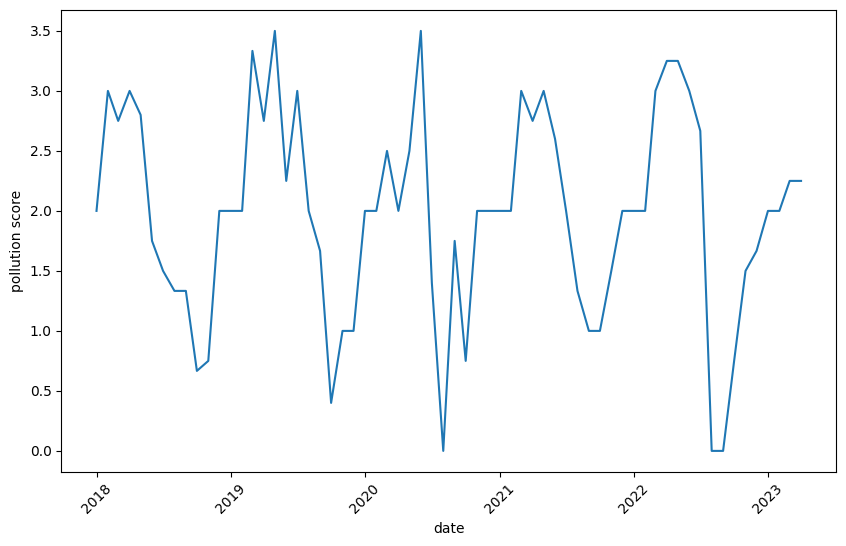

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['날짜'], df['pollution_score'])
plt.xlabel('date')
plt.ylabel('pollution score')
plt.xticks(rotation=45)
plt.show()

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['수온(℃)', 'cum_rainfall', 'PM10', '수소이온농도']
scaled_values = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_values, columns=scale_cols)

scaled_df = scaled_df.reset_index()
scaled_df

,index,수온(℃),cum_rainfall,PM10,수소이온농도
0,0,0.000000,0.000000,0.289953,0.538462
1,1,0.177449,0.000000,0.470446,0.230769
2,2,0.426063,0.023148,0.407402,0.192308
3,3,0.533272,0.033951,0.529616,0.153846
4,4,0.685397,0.156790,0.520666,0.138462
...,...,...,...,...,...
59,59,0.176217,0.004115,0.243970,0.461538
60,60,0.292052,0.000000,0.765747,0.230769
61,61,0.234750,0.000000,0.272254,0.538462
62,62,0.428835,0.020062,1.000000,0.384615


In [9]:
save = df[['pollution_score']]
save = save.reset_index()
save

,index,pollution_score
0,0,2.000000
1,1,3.000000
2,2,2.750000
3,3,3.000000
4,4,2.800000
...,...,...
59,59,1.666667
60,60,2.000000
61,61,2.000000
62,62,2.250000


In [10]:
df = pd.merge(scaled_df, save, on='index')
df.drop('index', axis = 1, inplace = True)
df

,수온(℃),cum_rainfall,PM10,수소이온농도,pollution_score
0,0.000000,0.000000,0.289953,0.538462,2.000000
1,0.177449,0.000000,0.470446,0.230769,3.000000
2,0.426063,0.023148,0.407402,0.192308,2.750000
3,0.533272,0.033951,0.529616,0.153846,3.000000
4,0.685397,0.156790,0.520666,0.138462,2.800000
...,...,...,...,...,...
59,0.176217,0.004115,0.243970,0.461538,1.666667
60,0.292052,0.000000,0.765747,0.230769,2.000000
61,0.234750,0.000000,0.272254,0.538462,2.000000
62,0.428835,0.020062,1.000000,0.384615,2.250000


In [11]:
feature_cols = ['수온(℃)', 'cum_rainfall', 'PM10', '수소이온농도', 'pollution_score']
label_cols = ['pollution_score']

label_df = pd.DataFrame(df, columns = label_cols)
feature_df = pd.DataFrame(df, columns = feature_cols)

print(feature_df)
print(label_df)

label_np = label_df.to_numpy()
feature_np = feature_df.to_numpy()

       수온(℃)  cum_rainfall      PM10    수소이온농도  pollution_score
0   0.000000      0.000000  0.289953  0.538462         2.000000
1   0.177449      0.000000  0.470446  0.230769         3.000000
2   0.426063      0.023148  0.407402  0.192308         2.750000
3   0.533272      0.033951  0.529616  0.153846         3.000000
4   0.685397      0.156790  0.520666  0.138462         2.800000
..       ...           ...       ...       ...              ...
59  0.176217      0.004115  0.243970  0.461538         1.666667
60  0.292052      0.000000  0.765747  0.230769         2.000000
61  0.234750      0.000000  0.272254  0.538462         2.000000
62  0.428835      0.020062  1.000000  0.384615         2.250000
63  0.527726      0.007716  0.550234  0.403846         2.250000

[64 rows x 5 columns]
    pollution_score
0          2.000000
1          3.000000
2          2.750000
3          3.000000
4          2.800000
..              ...
59         1.666667
60         2.000000
61         2.000000
62       

In [12]:
def make_sequence_dataset(feature, label, window_size):
    feature_list = []
    label_list = []
    
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
        
    return np.array(feature_list), np.array(label_list)

In [13]:
window_size = 3
X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(61, 3, 5) (61, 1)


In [14]:
split = -12

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(49, 3, 5) (49, 1)
(12, 3, 5) (12, 1)


In [15]:
from keras.layers import Dense, SimpleRNN, GRU

In [16]:
model = Sequential()

model.add(GRU(10,
             activation = 'tanh',
             input_shape=x_train[0].shape))

model.add(Dense(1, activation = 'linear'))
model.summary()

2023-07-06 18:19:09.919597: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-06 18:19:10.672329: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31211 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:2f:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10)                510       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [17]:
from keras.optimizers import Adam

In [18]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
def create_model(optimizer='adam', learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-07):
    model = Sequential()
    model.add(GRU(40, activation='tanh', input_shape=x_train[0].shape))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon), metrics=['mae'])
    return model

### KerasRegressor에 modified_GRU_model 함수를 사용합니다.
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=16, verbose=1)

# 매개변수 그리드 생성
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'beta_1': [0.9, 0.95, 0.99],
    'beta_2': [0.9, 0.95, 0.99],
    'epsilon': [1e-08, 1e-07, 1e-06]
}

# GridSearchCV를 사용하여 최적의 매개변수 탐색
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_result = grid_search.fit(x_train, y_train)

# 결과 출력
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.309979 using {'beta_1': 0.9, 'beta_2': 0.99, 'epsilon': 1e-08, 'learning_rate': 0.01}

In [24]:
optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.99, epsilon=1e-07)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 50, batch_size = 16)

Epoch 1/50
4/4 [==============================] - 2s 169ms/step - loss: 0.3441 - mae: 0.4543 - val_loss: 0.5783 - val_mae: 0.6523
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.3265 - mae: 0.4567 - val_loss: 0.4931 - val_mae: 0.5950
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 0.3027 - mae: 0.4243 - val_loss: 0.5021 - val_mae: 0.5663
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 0.3020 - mae: 0.4275 - val_loss: 0.5105 - val_mae: 0.6161
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 0.2866 - mae: 0.4173 - val_loss: 0.5322 - val_mae: 0.6358
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 0.2894 - mae: 0.4188 - val_loss: 0.5372 - val_mae: 0.6373
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 0.2970 - mae: 0.4302 - val_loss: 0.5411 - val_mae: 0.6402
Epoch 8/50
4/4 [==============================] - 0s 13ms/step - loss: 0.2751 - mae: 0.4101 - va

1/1 [==============================] - 0s 359ms/step


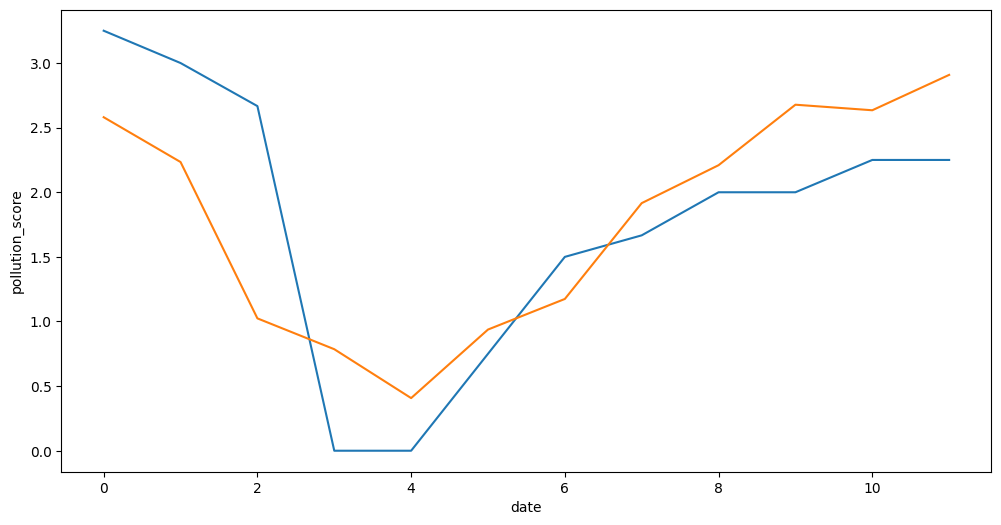

In [25]:
import matplotlib.ticker as ticker

pred = model.predict(x_test)

plt.figure(figsize=(12,6))
plt.ylabel('pollution_score')
plt.xlabel('date')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE, R2],
                         index = ['MAE', 'R2'],
                         columns=['Results'])
    return Result

In [27]:
y_pred_gru = pd.DataFrame(pred[:, 0])
y_test_gru=test['pollution_score'][0:len(pred)]
y_test_gru.reset_index(drop=True, inplace=True)

In [28]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,0.58025
R2,0.53435


In [167]:
confirm_result(y_test_gru, y_pred_gru) # 캡쳐해둔 그래프 지표

,Results
MAE,0.51503
R2,0.49867
